Links:
- https://github.com/hardmaru/WorldModelsExperiments
- http://blog.otoro.net//2018/06/09/world-models-experiments/


In [1]:
%matplotlib inline
import numpy as np
import importlib
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
from PIL import Image
import PIL
from torchsummary import summary

In [2]:
env = gym.make('MountainCar-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Mountain Car Environment

In [3]:
state = env.reset()
ims = []
for i in range(1000):
    action = env.action_space.sample()
    state, r, done, _ = env.step(action)
    im = env.render(mode='rgb_array')
    ims.append(im)
env.close()

In [4]:
resized_ims = [Image.fromarray(i).resize((64, 64), Image.BILINEAR) for i in ims]

In [5]:
resized_ims = [np.array(i) for i in resized_ims]

In [6]:
resized_ims = np.array(resized_ims)

In [156]:
# tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="dec_deconv1")
#       h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="dec_deconv2")
#       h = tf.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="dec_deconv3")

class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()
    def forward(self, x):
        x = x.view(-1,  4*256, 1, 1)
        return x

    

class VAE(nn.Module):
    def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001, kl_tolerance=0.5, gpu=False):
        self.z_size=z_size
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.kl_tolerance=kl_tolerance
        self.gpu = gpu
        
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        
        self.mu = nn.Linear(256*2*2, 32)
        self.logvar = nn.Linear(256*2*2, 32)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.z_size,4*256),
            Reshape(),
            nn.ConvTranspose2d(4*256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, 256*2*2)
        
        mu = self.mu(encoded)
        sigma = torch.exp(self.logvar(encoded)/2.0)
        eps = torch.randn(self.batch_size, self.z_size)
        z = mu + sigma * eps
        
        decoded = self.decoder(z)
        
        return decoded, encoded, z, mu, sigma
    
    def loss(self, ):
        

SyntaxError: invalid syntax (<ipython-input-156-064b795f1e6a>, line 64)

In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = VAE().to(device)

In [140]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           1,568
              ReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
              ReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
              ReLU-8            [-1, 256, 2, 2]               0
            Linear-9                   [-1, 32]          32,800
           Linear-10                   [-1, 32]          32,800
           Linear-11                 [-1, 1024]          33,792
          Reshape-12           [-1, 1024, 1, 1]               0
  ConvTranspose2d-13            [-1, 128, 5, 5]       3,276,928
             ReLU-14            [-1, 12

In [141]:
var = torch.from_numpy(resized_ims)
var = var.reshape((1000, 3, 64, 64)).float()

x = model.forward(var)

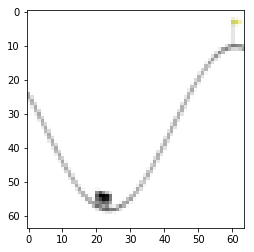

In [155]:
plt.imshow(resized_ims[0])

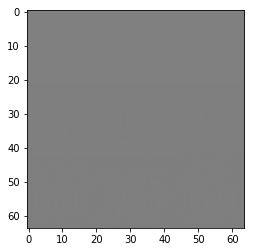

In [154]:
plt.imshow(x[0].detach().numpy().reshape((64,64,3)))